In [97]:
import sys

for module_name in ["producer", "sqlite", "mongo"]:
    try:
        del sys.modules[module_name]
    except:
        pass


In [99]:
import pandas as pd
import producer
from producer import binance_data, BatchMode
from time import perf_counter
from functools import reduce

from sqlite import InsertSQLite, PandasSQLite
from mongo import MongoBasic, MongoTimeSerie

engines = (InsertSQLite(), PandasSQLite(), MongoBasic(), MongoTimeSerie())
batch_modes = (BatchMode.DICT, BatchMode.DF, BatchMode.DICT, BatchMode.TIME_DICT)
engine_names = ("SQLite via insert", "SQLite via pandas.to_sql", "Mongo standard", "Mongo avec TimeSerie")
batches = [10 ** i for i in range(4)]
avg_samples = 10

def human_number(n):
    def gen_units():
        for unit in ["U", "K", "M", "G", "T", "P"]:
            yield unit
    
    units = gen_units()
    unit = next(units)
    while round(n) >= 1000:
        n /= 1000.0
        try:
            unit = next(units)
        except StopIteration:
            break
    return str(round(n)) + unit

stats = pd.DataFrame(index=batches)
for (engine, batch_mode, engine_name) in zip(engines, batch_modes, engine_names):
    db_size = 0
    for _ in range(2):
        avgs = []
        mins = []
        for nbatch in batches:
            elapses = []
            for i in range(avg_samples):
                batch = binance_data(nbatch, mode=batch_mode)
                start = perf_counter()
                engine.write_batch(batch)
                end = perf_counter()
                elapses.append(end - start)
            # print(f"•••  up  ••• elapsed for batch of {nbatch} = {total / avg_samples / nbatch} per row")
            avgs.append(reduce(lambda x, y: x+y, elapses) / avg_samples / nbatch)
            mins.append(min(elapses) / nbatch)
        stats[engine_name, human_number(db_size), "avg"] = avgs
        stats[engine_name, human_number(db_size), "min"] = mins
        db_size += avg_samples * reduce(lambda x, y: x+y, batches)

        # avgs = []
        # for nbatch in batches:
        #     total = 0
        #     for i in range(avg_samples):
        #         batch = binance_data(nbatch, mode=batch_mode)
        #         start = perf_counter()
        #         engine.write_batch(batch)
        #         end = perf_counter()
        #         total += end - start
        #     # print(f"••• down ••• elapsed for batch of {nbatch} = {total / avg_samples / nbatch} per row")
        #     avgs.append(total / avg_samples / nbatch)
        # db_size = avg_samples * reduce(lambda x, y: x+y, batches)
        # stats[engine_name, human_number(db_size)] = avgs

stats.columns = pd.MultiIndex.from_tuples(stats.columns, names=["DB", "size"])
stats


DB     SQLite via insert           SQLite via pandas.to_sql            \
size                  0U        1M                       0U        1M   
1               0.003682  0.001929                 0.006845  0.009003   
10              0.000260  0.000185                 0.000683  0.002953   
100             0.000028  0.000029                 0.000071  0.000393   
1000            0.000009  0.000010                 0.000015  0.000113   
10000           0.000026  0.000012                 0.000019  0.000019   
100000          0.000013  0.000012                 0.000014  0.000012   

DB     Mongo standard           Mongo avec TimeSerie            
size               0U        1M                   0U        1M  
1            0.003399  0.002228             0.004123  0.003327  
10           0.000335  0.000339             0.000304  0.000320  
100          0.000067  0.000053             0.000121  0.000068  
1000         0.000031  0.000057             0.000074  0.000055  
10000        0.000073  0.000028             0.000054  0.000039  
100000       0.000056  0.000030             0.000039  0.000041

In [96]:
binance_data(5, mode=BatchMode.TIME_DICT)

[{'open': 15847.85,
  'high': 15853.62,
  'low': 15841.75,
  'close': 15841.75,
  'volume': 2.17907,
  'timestamp': datetime.datetime(2000, 1, 1, 12, 20, 55),
  'metadata': {'symbol': 'BTCEUR', 'interval': '1s'}},
 {'open': 15840.0,
  'high': 15842.47,
  'low': 15833.9,
  'close': 15834.03,
  'volume': 1.59663,
  'timestamp': datetime.datetime(2000, 1, 1, 12, 20, 56),
  'metadata': {'symbol': 'BTCEUR', 'interval': '1s'}},
 {'open': 15834.16,
  'high': 15845.08,
  'low': 15834.16,
  'close': 15836.04,
  'volume': 0.1585,
  'timestamp': datetime.datetime(2000, 1, 1, 12, 20, 57),
  'metadata': {'symbol': 'BTCEUR', 'interval': '1s'}},
 {'open': 15836.44,
  'high': 15839.3,
  'low': 15835.01,
  'close': 15836.07,
  'volume': 0.05736,
  'timestamp': datetime.datetime(2000, 1, 1, 12, 20, 58),
  'metadata': {'symbol': 'BTCEUR', 'interval': '1s'}},
 {'open': 15838.15,
  'high': 15841.82,
  'low': 15834.22,
  'close': 15841.26,
  'volume': 0.21867,
  'timestamp': datetime.datetime(2000, 1, 1, 12

In [28]:
import pandas as pd

batches = [10 ** i for i in range(5)]
stats = pd.DataFrame(index=batches + list(reversed(batches)))

stats["data"] = [i ** 3 for i in range(2*len(batches))]
stats


,data
1,0
10,1
100,8
1000,27
10000,64
10000,125
1000,216
100,343
10,512
1,729


In [100]:
min(1, 2, 3, 7)

1

In [49]:
import pandas as pd

batches = [10 ** i for i in range(5)]
stats = pd.DataFrame(index=batches)

# index = pd.MultiIndex.from_tuples([("sql", "0")], names=["first", "second"])
stats["index"] = [i ** 3 for i in range(len(batches))]
# index = pd.MultiIndex.from_tuples([("sql", "11M")], names=["first", "second"])
#stats[index] = [i ** 2 for i in range(len(batches))]
stats


Index([('sql', '0'), ('sql', '11M')], dtype='object')

In [53]:
import pandas as pd

batches = [10 ** i for i in range(5)]
stats = pd.DataFrame(index=batches)

stats["sql", "0"] = [i ** 3 for i in range(len(batches))]
stats["sql", "11M"] = [i ** 2 for i in range(len(batches))]
stats.columns = pd.MultiIndex.from_tuples(stats.columns, names=["DB", "size"])
stats

DB    sql    
size    0 11M
1       0   0
10      1   1
100     8   4
1000   27   9
10000  64  16

In [83]:
d = {"azer": 1}
d["x"] and True


KeyError: 'x'

In [7]:
sample_data = []
for row in binance_response.json():
    sample_data.append([float(cell) for cell in row[1:6]])
sample_data

[[15854.48, 15859.45, 15849.28, 15856.67, 0.68881],
 [15851.98, 15855.82, 15844.21, 15845.07, 1.06081],
 [15845.97, 15853.87, 15844.49, 15848.21, 0.77838],
 [15849.56, 15852.57, 15845.63, 15848.59, 0.33867],
 [15847.0, 15854.56, 15844.45, 15847.62, 0.27937],
 [15847.85, 15853.62, 15841.75, 15841.75, 2.17907],
 [15840.0, 15842.47, 15833.9, 15834.03, 1.59663],
 [15834.16, 15845.08, 15834.16, 15836.04, 0.1585],
 [15836.44, 15839.3, 15835.01, 15836.07, 0.05736],
 [15838.15, 15841.82, 15834.22, 15841.26, 0.21867]]

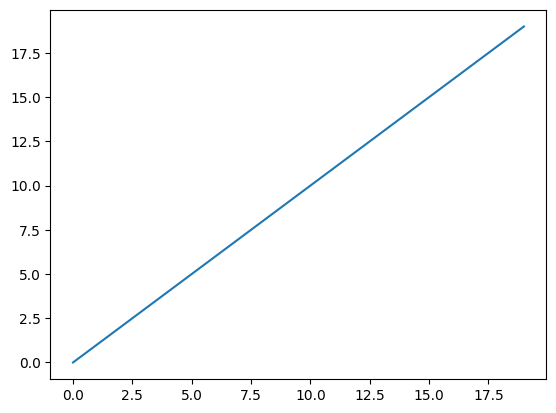

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(20));